# Imports

In [69]:
import tensorflow as tf
from math import sqrt
import numpy as np
import random
import sys, os
import cv2
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D
import keras.losses
import keras.optimizers
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.optimizers import SGD, Adam
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Convolution2D, MaxPooling2D, Flatten, BatchNormalization
from keras.applications import MobileNetV2
from keras.preprocessing import image_dataset_from_directory
import subprocess, os, shutil


from keras.utils.np_utils import to_categorical   
import subprocess, os, shutil

In [23]:
N_CLASSES=10

# Mounting drive

In [24]:
import subprocess, os, shutil
subprocess.run(['apt-get', 'install', 'unzip'])

CompletedProcess(args=['apt-get', 'install', 'unzip'], returncode=0)

In [25]:
#from google.colab import drive
#drive.mount('drive')

In [26]:
for folder in ['itl_dataset', 'output_proper', 'output_bbox', 'output_proper', 'output_color']:
  if os.path.exists(folder):
    shutil.rmtree(folder)
print(os.getcwd())
VERSION=8
subprocess.run(['wget', f'http://students.mimuw.edu.pl/~mt406390/machine_learning/itl_dataset_v{VERSION}.zip'])
subprocess.run(['unzip', f'itl_dataset_v{VERSION}.zip'], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

/content


CompletedProcess(args=['unzip', 'itl_dataset_v8.zip'], returncode=1)

# Loading data

In [27]:
import json
with open('annotations.json', 'r') as flabels:
  annots = json.load(flabels)

with open('config/operators.json', 'r') as operatorsfile:
  operators = json.load(operatorsfile)

annots = list(filter(lambda x: len(x['exprs']) != 0, annots))

In [28]:
print(len(annots))

6127


In [29]:
from keras.utils.np_utils import to_categorical   

op_labels = {j: to_categorical(i, num_classes=N_CLASSES) for i, j in enumerate(operators.keys())}
rev_operators = {i: j for i, j in enumerate(operators.keys())}
op_operators = {k : operators[k]['operands'] for k in operators.keys() }

print(op_labels)
print(rev_operators)
print(op_operators)


{'add': array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32), 'sub': array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32), 'mul': array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.], dtype=float32), 'frac': array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.], dtype=float32), 'sqrt': array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.], dtype=float32), 'int': array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32), 'par': array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.], dtype=float32), 'fpar': array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.], dtype=float32), 'ffpar': array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.], dtype=float32), 'gpar': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.], dtype=float32)}
{0: 'add', 1: 'sub', 2: 'mul', 3: 'frac', 4: 'sqrt', 5: 'int', 6: 'par', 7: 'fpar', 8: 'ffpar', 9: 'gpar'}
{'add': 2, 'sub': 2, 'mul': 2, 'frac': 2, 'sqrt': 1, 'int': 1, 'par': 1, 'fpar': 1, 'ffpar': 1, 'gpar': 1}


In [30]:
POINTS_PER_BOX=4
INPUT_SHAPE=(224, 224, 1)
N_CLASSES = len(op_labels)

In [31]:



def get_ds_shape(annots, operators):
  possible_operands = sorted([
      operators[k]['operands'] for k in operators.keys()
  ])

  print(possible_operands)

  ds_shape =  {
      operands_no: 0 for operands_no in possible_operands
  }

  for a in annots:
    ds_shape[op_operators[a['op']]]+=1

  return ds_shape, possible_operands


ds_shape, possible_operands = get_ds_shape(annots, operators)
print(ds_shape)

[1, 1, 1, 1, 1, 1, 2, 2, 2, 2]
{1: 1846, 2: 4281}


In [32]:
def get_datasets(ds_shape, annots):
  datasets = {
      i: {
          'operators': np.zeros((N, N_CLASSES)),
          'bboxes': np.zeros((N, i, POINTS_PER_BOX)),
          'paths': [None] * N,
          'size': 0
      } for i, N in ds_shape.items()
  }

  for j, a in enumerate(annots):
    idx = int(a['name'][len('eq') : a['name'].find('.')])
    operands_type = op_operators[a['op']]
    #assert(j == idx)

    idx = datasets[operands_type]['size']
    datasets[operands_type]['size']+=1

    datasets[operands_type]['operators'][idx] = op_labels[a['op']]

    for k in range(len(a['exprs'])):
        datasets[operands_type]['bboxes'][idx][k] = np.array(a['exprs'][k])

    datasets[operands_type]['paths'][idx] = os.path.join('output_proper', a['name'])
    

  return datasets


def merge_datasets(dataset_list, operands):
  assert(operands == sorted(operands))

  return {
      'operators': np.concatenate([dataset_list[j]['operators'] for j in operands]),
          'bboxes': None, # not used in merged
          'paths': sum((dataset_list[j]['paths'] for j in operands), []),
          'size': sum(dataset_list[j]['size'] for j in operands)
  }

In [33]:
datasets = get_datasets(ds_shape, annots)
turbo_dataset = merge_datasets(datasets, possible_operands)

In [34]:
from google.colab.patches import cv2_imshow

def load_img(path):
  return 255-cv2.cvtColor(imread(path), cv2.COLOR_BGR2GRAY).reshape(INPUT_SHAPE)

In [136]:
from skimage.io import imread
from skimage.transform import resize
import numpy as np
import math
from keras.utils import Sequence

class ITLSequence(Sequence):

    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return math.ceil(len(self.x) / self.batch_size)

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) *
        self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) *
        self.batch_size]
        return np.array([
            load_img(file_name) for file_name in batch_x], dtype=np.float64), batch_y


class ITLSequenceBox(Sequence):
    def __init__(self, paths, bboxes, batch_size, bboxes_no):
        self.x = paths
        
        boxes = bboxes.copy()

        #boxes[..., 2:] **= 2
        #boxes[..., ::2] /= INPUT_SHAPE[0]
        #boxes[..., 1::2] /= INPUT_SHAPE[1]
        self.y = boxes.reshape((-1, bboxes_no*POINTS_PER_BOX))
        
        self.batch_size = batch_size

    def __len__(self):
        return math.ceil(len(self.x) / self.batch_size)

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) *
        self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) *
        self.batch_size]
        return np.array([
            load_img(file_name) for file_name in batch_x], dtype=np.float64), batch_y



In [137]:
def restore_scale(p):
  return (p[0] * INPUT_SHAPE[0], p[1] * INPUT_SHAPE[1], (p[2] * INPUT_SHAPE[0]), (p[3] * INPUT_SHAPE[1]))


def restore_scale2(p):
  return (p[0], p[1], p[2], p[3])

In [138]:
annots[0]

{'exprs': [[18, 91, 86, 40], [119, 101, 84, 19]],
 'label': '\\int f\\left(y-8\\right) \\cdot f\\left(3c \\cdot \\left(bc\\right)\\right)',
 'name': 'eq0.png',
 'op': 'mul'}

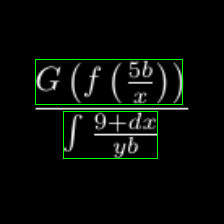

In [139]:
def show_input(dataset, i):
    cv2img = load_img(dataset['paths'][i])
    cv2img = cv2.cvtColor(cv2img, cv2.COLOR_GRAY2BGR)
    for x, y, dx, dy in dataset['bboxes'][i]:
        cv2.rectangle(cv2img, (int(x), int(y)), (int(x+dx), int(y+dy)), [0,255, 0], 1)
    cv2_imshow(cv2img)  

show_input(datasets[2], 2001)

In [140]:
itlseq = ITLSequence(turbo_dataset['paths'], turbo_dataset['operators'], 64)

BOXES_SUPPORTED=1
bbox_seq = ITLSequenceBox(datasets[BOXES_SUPPORTED]['paths'], datasets[BOXES_SUPPORTED]['bboxes'], 64, BOXES_SUPPORTED)

In [141]:
print(len(op_labels))

10


# Model


In [142]:
from pdb import set_trace
import tensorflow as tf

def get_model_operator(verbose=False):
    model = tf.keras.applications.MobileNetV2(weights=None, classes=len(op_labels), input_shape=INPUT_SHAPE)
    opt = Adam(learning_rate=0.001)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

def get_model_box(boxes_no, verbose=False):
    model = Sequential()
    model.add(Conv2D(8, kernel_size=(5, 5), activation='relu', input_shape=INPUT_SHAPE))
    model.add(BatchNormalization())
    model.add(Conv2D(16, kernel_size=(5, 5), activation='relu'))
    model.add(Conv2D(16, kernel_size=(5, 5), activation='relu'))
    model.add(Conv2D(16, kernel_size=(5, 5), activation='relu'))
    model.add(Flatten())
    model.add(Dropout(0.25))
    model.add(Dense(boxes_no*4))

    model.summary()
    model.compile('adam', 'mse')
    return model

def get_model_box2(boxes_no, verbose=False):
    model = Sequential()   
    model.add(tf.keras.applications.MobileNetV2(weights=None, include_top=False, input_shape=INPUT_SHAPE)) 
    model.add(Conv2D(32, kernel_size=(5, 5), activation='relu'))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(boxes_no*4))

    if verbose:
      model.summary()

    model.compile('adam', 'mse')

    return model


In [143]:
mdl = get_model_operator()

In [144]:
#mdl.fit(x=itlseq, batch_size=64, epochs=1)
print(datasets[BOXES_SUPPORTED]['paths'][:2])

['output_proper/eq3.png', 'output_proper/eq5.png']


In [145]:
bmdl2 = get_model_box(BOXES_SUPPORTED)

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 220, 220, 8)       208       
_________________________________________________________________
batch_normalization_6 (Batch (None, 220, 220, 8)       32        
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 216, 216, 16)      3216      
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 212, 212, 16)      6416      
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 208, 208, 16)      6416      
_________________________________________________________________
flatten_10 (Flatten)         (None, 692224)            0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 692224)          

In [146]:
bmdl2.fit(x=bbox_seq, batch_size=64, epochs=10)

Epoch 1/10
29/29 [==============================] - 4s 149ms/step - loss: 1658.9072
Epoch 2/10
29/29 [==============================] - 4s 149ms/step - loss: 133.9624
Epoch 3/10
29/29 [==============================] - 4s 149ms/step - loss: 68.0861
Epoch 4/10
29/29 [==============================] - 4s 148ms/step - loss: 45.7306
Epoch 5/10
29/29 [==============================] - 4s 150ms/step - loss: 33.8303
Epoch 6/10
29/29 [==============================] - 4s 148ms/step - loss: 24.8732
Epoch 7/10
29/29 [==============================] - 4s 149ms/step - loss: 17.9855
Epoch 8/10
29/29 [==============================] - 4s 149ms/step - loss: 15.6432
Epoch 9/10
29/29 [==============================] - 4s 149ms/step - loss: 13.1776
Epoch 10/10
29/29 [==============================] - 4s 148ms/step - loss: 10.9026


In [147]:
import cv2
from google.colab.patches import cv2_imshow
def visualize(path, idx, model):
  infer = load_img(path)
  cv2img = load_img(path)
  cv2_imshow(cv2img)
  cv2img=cv2.cvtColor(cv2img, cv2.COLOR_GRAY2BGR)
  batch = np.zeros((1,*INPUT_SHAPE), dtype=np.float64)
  batch[0] = infer
  points=model.predict_on_batch(batch)[0]
  predicted_boxes_no = len(points) / POINTS_PER_BOX
  print(points)
  def draw_rect(x,y,dx,dy):
    cv2.rectangle(cv2img, (int(x), int(y)), (int(x+dx), int(y+dy)), [0,0,255], 3)

  for j in range(0, len(points), POINTS_PER_BOX):
    x,y,dx,dy = restore_scale2((points[j], points[j+1], points[j+2], points[j+3]))
    draw_rect(x,y,dx,dy)

  print(idx)
  cv2_imshow(cv2img)




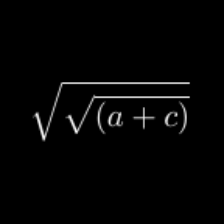

[ 63.168316  92.70474  120.99885   37.061504]
0


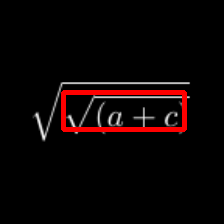

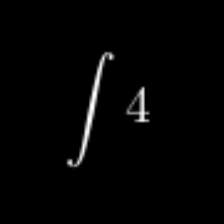

[126.24433   87.0942    22.004875  33.023487]
1


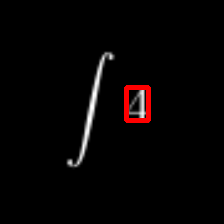

In [148]:
for j in range(2):
  visualize(datasets[BOXES_SUPPORTED]['paths'][j], j, bmdl2)

In [128]:
mdl.save('itl_op')

INFO:tensorflow:Assets written to: itl_op/assets
